In [ ]:
import numpy as np

class FC:
    """
    Fully connected layer from n_nodes1 to n_nodes2
    
    Parameters
    ----------
    n_nodes1 : int
        Number of nodes in the previous layer
    n_nodes2 : int
        Number of nodes in the next layer
    initializer : Initializer instance
        Weight initializer
    optimizer : Optimizer instance
        Optimization algorithm
    """
    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.optimizer = optimizer
        
        #weights and biases
        self.W = initializer.initialize((n_nodes1, n_nodes2))
        self.B = initializer.initialize((1, n_nodes2))
        
        # Variables to store during forward pass for backward pass
        self.X = None
        self.dW = None
        self.dB = None
    
    def forward(self, X):
        """
        Forward pass through the layer
        
        Parameters
        ----------
        X : ndarray, shape (batch_size, n_nodes1)
            Input data
            
        Returns
        -------
        A : ndarray, shape (batch_size, n_nodes2)
            Output before activation
        """
        self.X = X  # Store for backward pass
        A = np.dot(X, self.W) + self.B
        return A
    
    def backward(self, dA):
        """
        Backward pass through the layer
        
        Parameters
        ----------
        dA : ndarray, shape (batch_size, n_nodes2)
            Gradient from the next layer
            
        Returns
        -------
        dZ : ndarray, shape (batch_size, n_nodes1)
            Gradient to previous layer
        """
        batch_size = dA.shape[0]
        
        #gradients
        self.dW = np.dot(self.X.T, dA) / batch_size
        self.dB = np.sum(dA, axis=0, keepdims=True) / batch_size
        dZ = np.dot(dA, self.W.T)
        
        #
        self = self.optimizer.update(self)
        
        return dZ

In [11]:
import numpy as np

class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    
    Parameters
    ----------
    sigma : float
        Standard deviation of Gaussian distribution
    """
    
    def __init__(self, sigma):
        self.sigma = sigma
    
    def W(self, n_nodes1, n_nodes2):
        """
        Weight initialization
        
        Parameters
        ----------
        n_nodes1 : int
            Number of nodes in the previous layer
        n_nodes2 : int
            Number of nodes in the next layer
            
        Returns
        -------
        W : ndarray, shape (n_nodes1, n_nodes2)
            Initialized weight matrix
        """
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        """
        Bias initialization
        
        Parameters
        ----------
        n_nodes2 : int
            Number of nodes in the next layer
            
        Returns
        -------
        B : ndarray, shape (1, n_nodes2)
            Initialized bias vector
        """
        return np.zeros((1, n_nodes2))

In [ ]:
class SGD:
    """
    Stochastic Gradient Descent optimizer
    
    Parameters
    ----------
    lr : float
        Learning rate
    """
    
    def __init__(self, lr):
        self.lr = lr
    
    def update(self, layer):
        """
        Update layer parameters using gradients
        
        Parameters
        ----------
        layer : FC layer instance
            The layer containing parameters to update (must have W, B, dW, dB attributes)
            
        Returns
        -------
        layer : FC layer instance
            The layer with updated parameters
        """
        # weights
        layer.W -= self.lr * layer.dW
        
        # biases
        layer.B -= self.lr * layer.dB
        
        return layer

In [13]:
import numpy as np

class Sigmoid:
    """Sigmoid activation function"""
    
    def forward(self, A):
        """
        Forward pass
        A : Input (batch_size, n_nodes)
        Returns output (batch_size, n_nodes)
        """
        self.A = A
        return 1 / (1 + np.exp(-A))
    
    def backward(self, dZ):
        """
        Backward pass
        dZ : Gradient from next layer (batch_size, n_nodes)
        Returns gradient to previous layer (batch_size, n_nodes)
        """
        sig = 1 / (1 + np.exp(-self.A))
        return dZ * sig * (1 - sig)

class Tanh:
    """Hyperbolic tangent activation function"""
    
    def forward(self, A):
        """
        Forward pass
        A : Input (batch_size, n_nodes)
        Returns output (batch_size, n_nodes)
        """
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        """
        Backward pass
        dZ : Gradient from next layer (batch_size, n_nodes)
        Returns gradient to previous layer (batch_size, n_nodes)
        """
        return dZ * (1 - np.tanh(self.A)**2)

class ReLU:
    """Rectified Linear Unit activation function"""
    
    def forward(self, A):
        """
        Forward pass
        A : Input (batch_size, n_nodes)
        Returns output (batch_size, n_nodes)
        """
        self.A = A
        return np.maximum(0, A)
    
    def backward(self, dZ):
        """
        Backward pass
        dZ : Gradient from next layer (batch_size, n_nodes)
        Returns gradient to previous layer (batch_size, n_nodes)
        """
        return dZ * (self.A > 0).astype(float)

class SoftmaxWithLoss:
    """Softmax activation with cross-entropy loss (combined for numerical stability)"""
    
    def forward(self, A):
        """
        Forward pass
        A : Input (batch_size, n_classes)
        Returns probabilities (batch_size, n_classes)
        """
        exp_A = np.exp(A - np.max(A, axis=1, keepdims=True))
        self.y_pred = exp_A / np.sum(exp_A, axis=1, keepdims=True)
        return self.y_pred
    
    def backward(self, y_true):
        """
        Backward pass (combines softmax and cross-entropy derivatives)
        y_true : True labels (batch_size, n_classes)
        Returns gradient to previous layer (batch_size, n_classes)
        """
        return (self.y_pred - y_true) / y_true.shape[0]

In [ ]:
import numpy as np

class ReLU:
    """
    Rectified Linear Unit (ReLU) activation function
    
    ReLU(x) = max(0, x)
    """
    
    def forward(self, A):
        """
        Forward pass through ReLU activation
        
        Parameters
        ----------
        A : ndarray
            Input array from the previous layer (any shape)
            
        Returns
        -------
        ndarray
            Output after applying ReLU activation
        """
        self.A = A  
        return np.maximum(0, A)
    
    def backward(self, dZ):
        """
        Backward pass through ReLU activation
        
        Parameters
        ----------
        dZ : ndarray
            Gradient from the next layer (same shape as forward input)
            
        Returns
        -------
        ndarray
            Gradient to pass to previous layer
        """
        #mask where input > 0
        mask = (self.A > 0).astype(float)
        return dZ * mask

In [15]:
import numpy as np

class XavierInitializer:
    """
    Xavier/Glorot initialization for sigmoid/tanh activations
    
    σ = 1/sqrt(n_input)
    """
    
    def __init__(self):
        pass
    
    def W(self, n_nodes1, n_nodes2):
        """
        Initialize weights
        n_nodes1: Number of nodes in previous layer
        n_nodes2: Number of nodes in next layer
        """
        sigma = 1 / np.sqrt(n_nodes1)
        return sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        """
        Initialize biases (zeros)
        n_nodes2: Number of nodes in next layer
        """
        return np.zeros((1, n_nodes2))

class HeInitializer:
    """
    He initialization for ReLU activations
    
    σ = sqrt(2/n_input)
    """
    
    def __init__(self):
        pass
    
    def W(self, n_nodes1, n_nodes2):
        """
        Initialize weights
        n_nodes1: Number of nodes in previous layer
        n_nodes2: Number of nodes in next layer
        """
        sigma = np.sqrt(2 / n_nodes1)
        return sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        """
        Initialize biases (zeros)
        n_nodes2: Number of nodes in next layer
        """
        return np.zeros((1, n_nodes2))

In [ ]:
import numpy as np

class AdaGrad:
    """
    AdaGrad optimization method
    
    Parameters
    ----------
    lr : float
        Base learning rate
    epsilon : float (default=1e-8)
        Small value to prevent division by zero
    """
    
    def __init__(self, lr=0.01, epsilon=1e-8):
        self.lr = lr
        self.epsilon = epsilon
        self.H_w = None  # Sum of squared gradients for weights
        self.H_b = None  # Sum of squared gradients for biases
    
    def update(self, layer):
        """
        Update layer parameters using AdaGrad
        
        Parameters
        ----------
        layer : FC layer instance
            Layer containing parameters to update (must have W, B, dW, dB attributes)
            
        Returns
        -------
        layer : FC layer instance
            The layer with updated parameters
        """
        # Initialize H if first run
        if self.H_w is None:
            self.H_w = np.zeros_like(layer.W)
            self.H_b = np.zeros_like(layer.B)
        
        # sum of squared gradients (H)
        self.H_w += layer.dW ** 2
        self.H_b += layer.dB ** 2
        
        #weights with adaptive learning rate
        layer.W -= self.lr * layer.dW / (np.sqrt(self.H_w) + self.epsilon)
        
        #biases with adaptive learning rate
        layer.B -= self.lr * layer.dB / (np.sqrt(self.H_b) + self.epsilon)
        
        return layer

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder

class ScratchDeepNeuralNetworkClassifier(BaseEstimator, ClassifierMixin):
    """
    Deep Neural Network Classifier from scratch
    
    Parameters
    ----------
    n_nodes_list : list of int
        Number of nodes in each hidden layer
    activation : str (default='relu')
        Activation function ('relu', 'sigmoid', 'tanh')
    initializer : str (default='he')
        Weight initializer ('he', 'xavier', 'simple')
    optimizer : str (default='sgd')
        Optimization method ('sgd', 'adagrad')
    lr : float (default=0.01)
        Learning rate
    sigma : float (default=0.1)
        Standard deviation for simple initializer
    epochs : int (default=10)
        Number of training epochs
    batch_size : int (default=20)
        Mini-batch size
    verbose : bool (default=True)
        Print training progress
    """
    
    def __init__(self, n_nodes_list=[400, 200], activation='relu', initializer='he',
                 optimizer='sgd', lr=0.01, sigma=0.1, epochs=10, batch_size=20, verbose=True):
        self.n_nodes_list = n_nodes_list
        self.activation = activation
        self.initializer = initializer
        self.optimizer = optimizer
        self.lr = lr
        self.sigma = sigma
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.loss_train = []
        self.loss_val = []
        self.layers = []
        self.activations = []
    
    def _initialize_network(self, n_features, n_output):
        """Initialize network architecture"""
        # 
        if self.initializer == 'he':
            initializer = HeInitializer()
        elif self.initializer == 'xavier':
            initializer = XavierInitializer()
        else:
            initializer = SimpleInitializer(self.sigma)
        
        #
        if self.optimizer == 'adagrad':
            optimizer = AdaGrad(self.lr)
        else:
            optimizer = SGD(self.lr)
        
        # 
        activation_map = {
            'relu': ReLU(),
            'sigmoid': Sigmoid(),
            'tanh': Tanh()
        }
        hidden_activation = activation_map.get(self.activation, ReLU())
        
        # network layers
        self.layers = []
        self.activations = []
        
        # Input layer
        n_in = n_features
        for n_out in self.n_nodes_list:
            self.layers.append(FC(n_in, n_out, initializer, optimizer))
            self.activations.append(hidden_activation)
            n_in = n_out
        
        # Output layer
        self.layers.append(FC(n_in, n_output, initializer, optimizer))
        self.activations.append(SoftmaxWithLoss())
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Train the deep neural network
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Training data
        y : ndarray, shape (n_samples,)
            Target values
        X_val : ndarray, shape (n_val_samples, n_features)
            Validation data
        y_val : ndarray, shape (n_val_samples,)
            Validation targets
        """
        # One-hot encode labels
        self.enc_ = OneHotEncoder(sparse=False)
        y_onehot = self.enc_.fit_transform(y.reshape(-1, 1))
        
        if X_val is not None and y_val is not None:
            y_val_onehot = self.enc_.transform(y_val.reshape(-1, 1))
        
        # Initialize network
        n_features = X.shape[1]
        n_output = y_onehot.shape[1]
        self._initialize_network(n_features, n_output)
        
        # Training loop
        for epoch in range(self.epochs):
            # Mini-batch training
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y_onehot[indices]
            
            for i in range(0, X.shape[0], self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]
                
                # Forward pass
                A = X_batch
                for layer, activation in zip(self.layers, self.activations[:-1]):
                    A = layer.forward(A)
                    A = activation.forward(A)
                
                # Output layer (with softmax + cross-entropy)
                A = self.layers[-1].forward(A)
                y_pred = self.activations[-1].forward(A)
                
                # Backward pass
                dA = self.activations[-1].backward(y_batch)
                for layer, activation in zip(reversed(self.layers[1:]), 
                                           reversed(self.activations[:-1])):
                    dZ = layer.backward(dA)
                    dA = activation.backward(dZ)
                
                # First layer
                self.layers[0].backward(dA)
            
            # Calculate losses
            train_loss = self._calculate_loss(X, y_onehot)
            self.loss_train.append(train_loss)
            
            if X_val is not None and y_val is not None:
                val_loss = self._calculate_loss(X_val, y_val_onehot)
                self.loss_val.append(val_loss)
            
            if self.verbose:
                if X_val is not None and y_val is not None:
                    print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
                else:
                    print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}")
    
    def _calculate_loss(self, X, y_onehot):
        """Calculate loss for given data"""
        A = X
        for layer, activation in zip(self.layers, self.activations[:-1]):
            A = layer.forward(A)
            A = activation.forward(A)
        
        # Output layer
        A = self.layers[-1].forward(A)
        y_pred = self.activations[-1].forward(A)
        return self.activations[-1]._cross_entropy_loss(y_pred, y_onehot)
    
    def predict_proba(self, X):
        """Predict class probabilities"""
        A = X
        for layer, activation in zip(self.layers, self.activations[:-1]):
            A = layer.forward(A)
            A = activation.forward(A)
        
        # Output layer
        A = self.layers[-1].forward(A)
        return self.activations[-1].forward(A)
    
    def predict(self, X):
        """Predict class labels"""
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)


Training Shallow Sigmoid network...


c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5, Train Loss: 2.3002, Val Loss: 2.3016
Epoch 2/5, Train Loss: 2.2813, Val Loss: 2.2831
Epoch 3/5, Train Loss: 2.2717, Val Loss: 2.2734
Epoch 4/5, Train Loss: 2.2639, Val Loss: 2.2654
Epoch 5/5, Train Loss: 2.2563, Val Loss: 2.2576


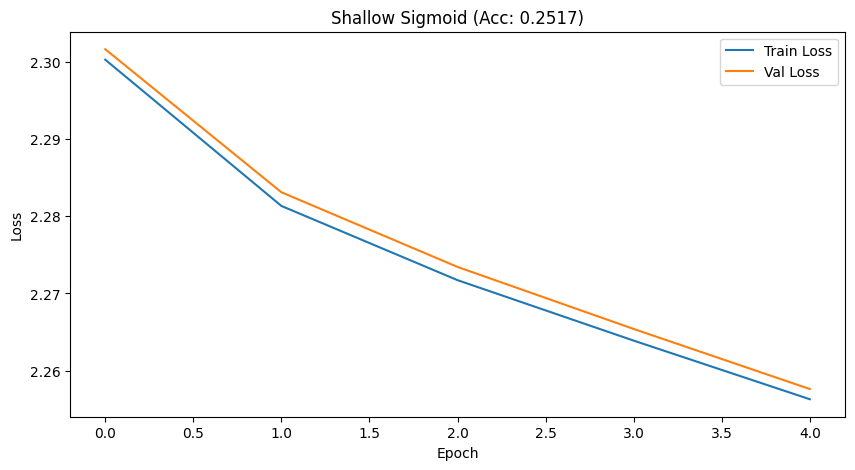


Training Deep ReLU network...


c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5, Train Loss: 2.0565, Val Loss: 2.0562
Epoch 2/5, Train Loss: 1.8563, Val Loss: 1.8496
Epoch 3/5, Train Loss: 1.6847, Val Loss: 1.6717
Epoch 4/5, Train Loss: 1.5367, Val Loss: 1.5179
Epoch 5/5, Train Loss: 1.4084, Val Loss: 1.3850


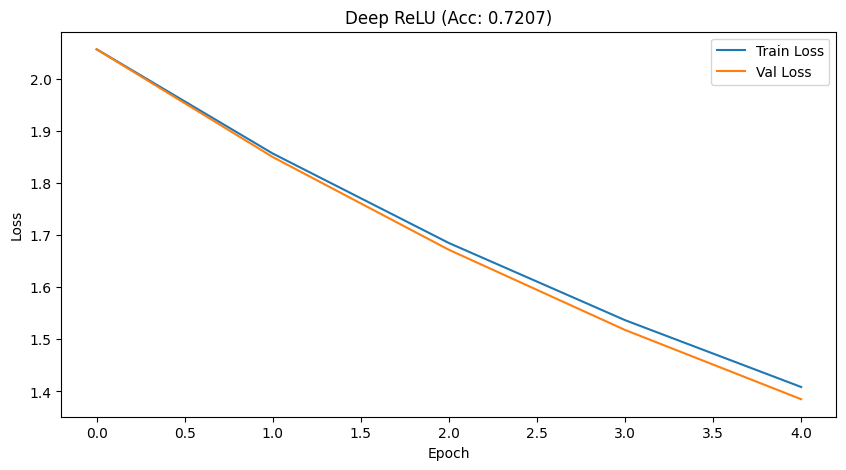


Training Medium Tanh network...


c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5, Train Loss: 2.2902, Val Loss: 2.2928
Epoch 2/5, Train Loss: 2.2309, Val Loss: 2.2300
Epoch 3/5, Train Loss: 2.1873, Val Loss: 2.1852
Epoch 4/5, Train Loss: 2.1433, Val Loss: 2.1396
Epoch 5/5, Train Loss: 2.0979, Val Loss: 2.0930


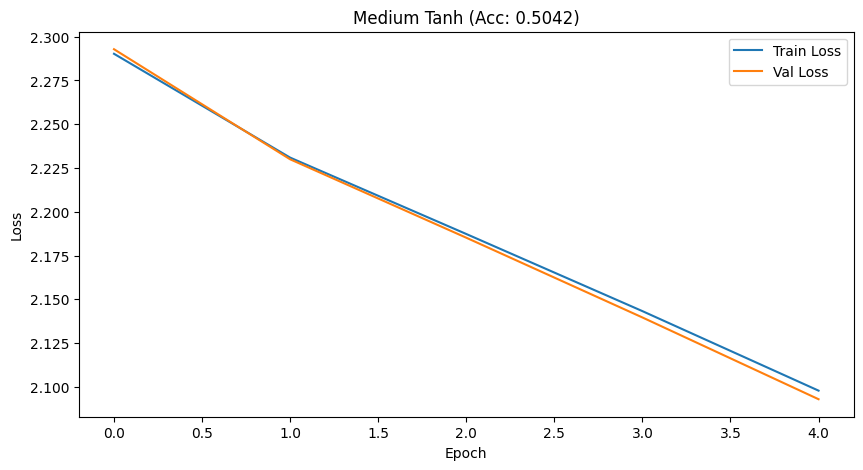


=== Final Results ===
Shallow Sigmoid: 0.2517
Deep ReLU: 0.7207
Medium Tanh: 0.5042


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder
from keras.datasets import mnist

# ====
# ====

class SimpleInitializer:
    def __init__(self, sigma=0.01):
        self.sigma = sigma
    
    def initialize(self, shape):
        return self.sigma * np.random.randn(*shape)

class XavierInitializer:
    def __init__(self):
        pass
    
    def initialize(self, shape):
        n_input = shape[0]
        sigma = 1 / np.sqrt(n_input)
        return sigma * np.random.randn(*shape)

class HeInitializer:
    def __init__(self):
        pass
    
    def initialize(self, shape):
        n_input = shape[0]
        sigma = np.sqrt(2 / n_input)
        return sigma * np.random.randn(*shape)

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer

class ReLU:
    def forward(self, A):
        self.A = A  # Store the input for backward pass
        return np.maximum(0, A)
    
    def backward(self, dZ):

        mask = (self.A > 0).astype(float)
        if mask.shape != dZ.shape:
            raise ValueError(f"Shape mismatch in ReLU backward: mask {mask.shape} vs dZ {dZ.shape}")
        return dZ * mask

class Sigmoid:
    def forward(self, A):
        self.A = A
        return 1 / (1 + np.exp(-A))
    
    def backward(self, dZ):
        sig = 1 / (1 + np.exp(-self.A))
        return dZ * sig * (1 - sig)

class Tanh:
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        return dZ * (1 - np.tanh(self.A)**2)

class SoftmaxWithLoss:
    def _cross_entropy_loss(self, y_pred, y_true):
        delta = 1e-7
        return -np.sum(y_true * np.log(y_pred + delta)) / len(y_pred)
    
    def forward(self, A):
        exp_A = np.exp(A - np.max(A, axis=1, keepdims=True))
        self.y_pred = exp_A / np.sum(exp_A, axis=1, keepdims=True)
        return self.y_pred
    
    def backward(self, y_true):
        return (self.y_pred - y_true) / y_true.shape[0]

class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.W = initializer.initialize((n_nodes1, n_nodes2))
        self.B = initializer.initialize((1, n_nodes2))
        self.optimizer = optimizer
        self.X = None
        self.dW = None
        self.dB = None
    
    def forward(self, X):
        self.X = X  # Store input for backward pass
        return np.dot(X, self.W) + self.B
    
    def backward(self, dA):
        batch_size = dA.shape[0]
        self.dW = np.dot(self.X.T, dA) / batch_size
        self.dB = np.sum(dA, axis=0, keepdims=True) / batch_size
        dZ = np.dot(dA, self.W.T)
        self = self.optimizer.update(self)
        return dZ

# ====
# ====

class ScratchDeepNeuralNetworkClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_nodes_list=[400, 200], activation='relu', initializer='he',
                 optimizer='sgd', lr=0.01, sigma=0.1, epochs=10, batch_size=20, verbose=True):
        self.n_nodes_list = n_nodes_list
        self.activation = activation
        self.initializer = initializer
        self.optimizer = optimizer
        self.lr = lr
        self.sigma = sigma
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.loss_train = []
        self.loss_val = []
    
    def _initialize_network(self, n_features, n_output):
        if self.initializer == 'he':
            initializer = HeInitializer()
        elif self.initializer == 'xavier':
            initializer = XavierInitializer()
        else:
            initializer = SimpleInitializer(self.sigma)
        
        if self.optimizer == 'adagrad':
            optimizer = AdaGrad(self.lr)
        else:
            optimizer = SGD(self.lr)
        
        activation_map = {
            'relu': ReLU(),
            'sigmoid': Sigmoid(),
            'tanh': Tanh()
        }
        hidden_activation = activation_map.get(self.activation, ReLU())
        
        self.layers = []
        self.activations = []
        n_in = n_features
        
        # 
        for n_out in self.n_nodes_list:
            self.layers.append(FC(n_in, n_out, initializer, optimizer))
            self.activations.append(hidden_activation)
            n_in = n_out
        
        #
        self.layers.append(FC(n_in, n_output, initializer, optimizer))
        self.activations.append(SoftmaxWithLoss())
    
    def fit(self, X, y, X_val=None, y_val=None):
        self.enc_ = OneHotEncoder(sparse=False)
        y_onehot = self.enc_.fit_transform(y.reshape(-1, 1))
        
        if X_val is not None and y_val is not None:
            y_val_onehot = self.enc_.transform(y_val.reshape(-1, 1))
        
        n_features = X.shape[1]
        n_output = y_onehot.shape[1]
        self._initialize_network(n_features, n_output)
        
        for epoch in range(self.epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y_onehot[indices]
            
            for i in range(0, X.shape[0], self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]
                
                # Forward pass
                A = X_batch
                for layer, activation in zip(self.layers, self.activations[:-1]):
                    A = layer.forward(A)
                    A = activation.forward(A)
                
                # Output layer
                A = self.layers[-1].forward(A)
                y_pred = self.activations[-1].forward(A)
                
                # Backward pass
                dA = self.activations[-1].backward(y_batch)
                
                # Go backwards through layers
                for i in reversed(range(len(self.layers)-1)):
                    dZ = self.layers[i+1].backward(dA)
                    # Get the stored activation from forward pass
                    self.activations[i].A = self.layers[i].X @ self.layers[i].W + self.layers[i].B
                    dA = self.activations[i].backward(dZ)
                
                #
                self.layers[0].backward(dA)
            
            #store losses
            train_loss = self._calculate_loss(X, y_onehot)
            self.loss_train.append(train_loss)
            
            if X_val is not None and y_val is not None:
                val_loss = self._calculate_loss(X_val, y_val_onehot)
                self.loss_val.append(val_loss)
            
            if self.verbose:
                if X_val is not None and y_val is not None:
                    print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
                else:
                    print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}")
    
    def _calculate_loss(self, X, y_onehot):
        A = X
        for layer, activation in zip(self.layers, self.activations[:-1]):
            A = layer.forward(A)
            A = activation.forward(A)
        
        A = self.layers[-1].forward(A)
        y_pred = self.activations[-1].forward(A)
        return self.activations[-1]._cross_entropy_loss(y_pred, y_onehot)
    
    def predict_proba(self, X):
        A = X
        for layer, activation in zip(self.layers, self.activations[:-1]):
            A = layer.forward(A)
            A = activation.forward(A)
        
        A = self.layers[-1].forward(A)
        return self.activations[-1].forward(A)
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

# ====
# ====

#MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784).astype(np.float32) / 255
X_test = X_test.reshape(-1, 784).astype(np.float32) / 255

#validation set
X_train, X_val = X_train[:50000], X_train[50000:]
y_train, y_val = y_train[:50000], y_train[50000:]

# Configurations to test
configurations = [
    {"name": "Shallow Sigmoid", "n_nodes_list": [256], "activation": "sigmoid", "initializer": "xavier", "optimizer": "sgd"},
    {"name": "Deep ReLU", "n_nodes_list": [512, 256], "activation": "relu", "initializer": "he", "optimizer": "sgd"},
    {"name": "Medium Tanh", "n_nodes_list": [400, 200], "activation": "tanh", "initializer": "xavier", "optimizer": "sgd"},
]

# Train and evaluate
results = []
for config in configurations:
    print(f"\nTraining {config['name']} network...")
    
    dnn = ScratchDeepNeuralNetworkClassifier(
        n_nodes_list=config["n_nodes_list"],
        activation=config["activation"],
        initializer=config["initializer"],
        optimizer=config["optimizer"],
        lr=0.01,
        epochs=5,  
        batch_size=64,
        verbose=True
    )
    
    dnn.fit(X_train, y_train, X_val, y_val)
    y_pred = dnn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append((config["name"], accuracy))
    
    plt.figure(figsize=(10, 5))
    plt.plot(dnn.loss_train, label='Train Loss')
    if dnn.loss_val:
        plt.plot(dnn.loss_val, label='Val Loss')
    plt.title(f"{config['name']} (Acc: {accuracy:.4f})")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

print("\n=== Final Results ===")
for name, acc in results:
    print(f"{name}: {acc:.4f}")